This is the template for DS3000 Final data analysis project. Once you finish, please remove all my instructions. You do not need to exactly follow the structure in the template but please make sure you have all the components. Write your report in paragraphs. Only use bullet points when list something (eg: functions) 

# Speed, Stamina, and Status: Analyzing Perfomance Metrics in Palworld
#### Team number: 5
- Maylin Vo, Ethan Kim, James Foehner

In [16]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
import pylab as py
import scipy.stats as stats
import plotly.express as px

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

## Introduction

Palworld is an open-world survival and creature-collection game in which players can explore a multitude of various environments all while capturing fantastical creatures known as "Pals". Each Pal can be assigned to various tasks such as combat and 
resource gathering. Also, each pal comes with its own unique set of attributes such as stamina and running speed. In a way, this is like compettitve analysis in real-life sports where understanding how these attributes interact can reveal deeper patterns in efficiency and effectiveness.

In this project, we are aiming to uncover statistical relationships between a Pal's physical performance and its perceived value within the game's ecosystem. Here is what we will explore:
1. Are a Pal's Stamina and running speed related?
2. What features affect a Pal's rank in the tier list?

This analysis not only gives insights for players looking for optimal team composition, but also provides a case study in applying data science techniques to a real-life-like dataset embedded in a game environment.

## Data 

### Data Source

- List the website you have scraped the data from.
- List which information you have scraped
- Describe what kind of cleaning you have done to the data

### Webscraping and cleaning functions overview

List all the functions you have written for webscraping and data cleaning. For each one, write one sentence to describe it. 
- `extract_soup()`
    - build url and return soup object

### Data overview

- Show a couple of rows of the cleaned data you are going to use for the analysis
- Which is your target value (if exists)
- Give a general summary about the other features
- Discuss if there is any potential problems about the data (eg: missing values, any features that you did not collect but may be important, any other concerns)

## Webscraping and cleaning

In [21]:
# list all the functions you have for webscraping and cleaning. Make sure write full 
# docstrings for each function
import csv
import time
import re
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup

BASE = "https://palworld.gg"
INDEX_URL = urljoin(BASE, "/pals")
HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; PalScraper/1.0; +https://example.com)"
}

def get_soup(url, retries=3, backoff=1.5):
    for i in range(retries):
        r = requests.get(url, headers=HEADERS, timeout=20)
        if r.status_code == 200:
            return BeautifulSoup(r.text, "html.parser")
        time.sleep(backoff * (i+1))
    r.raise_for_status()

def parse_index():
    soup = get_soup(INDEX_URL)
    pals = []
    
    for a in soup.select('a[href^="/pal/"]'):
        text = " ".join(a.get_text(" ", strip=True).split())
        name_match = re.match(r"(.+?)\s+#?(-?\d+)\s+(\d+)\s+(\w+)", text)
        
        if not name_match:
            # Fallback: just use the slug as name if needed
            slug = a.get("href").split("/")[-1]
            pals.append({
                "name": slug.replace("-", " ").title(),
                "number": "",
                "rarity": "",
                "url": urljoin(BASE, a.get("href"))
            })
            continue
        name, number, rarity_num, rarity_label = name_match.groups()
        pals.append({
            "name": name,
            "number": number,
            "rarity": rarity_label,
            "url": urljoin(BASE, a.get("href"))
        })

    seen = set()
    unique = []
    for p in pals:
        key = (p["name"], p["number"], p["url"])
        if key not in seen:
            seen.add(key)
            unique.append(p)
    return unique

def parse_detail(url):
    soup = get_soup(url)
    data = {}

    h1 = soup.select_one("h1")
    if h1:
        data["name_detail"] = h1.get_text(strip=True)

    elements = {"Fire","Water","Electricity","Leaf","Earth","Ice","Dragon","Dark","Normal"}
    text_all = soup.get_text("\n", strip=True)
    found_el = None
    for el in elements:
        if f"\n{el}\n" in text_all:
            found_el = el
            break
    data["element"] = found_el or ""

    stat_keys = ["HP","Defense","Crafting Speed","Melee Attack","Shot Attack",
                 "Price","Stamina","Support","Running Speed","Sprinting Speed","Slow Walk Speed"]
    for k in stat_keys:
        m = re.search(rf"\b{k}\b\s+(\d+)", text_all)
        data[k.lower().replace(" ", "_")] = m.group(1) if m else ""


    work = []
    work_section = text_all.split("Work Suitability")[-1] if "Work Suitability" in text_all else ""

    for line in work_section.splitlines():
        line = line.strip()
        if not line: 
            continue

        if line.startswith("Partner Skill") or line.startswith("Passive Skills") or line.startswith("Active Skills"):
            break

        if "Lv" in line:
            if work and "Lv" not in work[-1]:
                work[-1] = f"{work[-1]} ({line})"
            else:
                work.append(line)
        else:
            work.append(line)
    data["work_suitability"] = "; ".join([w for w in work if any(c.isalpha() for c in w)])

    partner = ""
    if "Partner Skill" in text_all:
        part = text_all.split("Partner Skill")[1]
        partner = part.split("Passive Skills")[0] if "Passive Skills" in part else part.split("Active Skills")[0] if "Active Skills" in part else part
        partner = partner.strip()
    data["partner_skill"] = partner


    passive = ""
    if "Passive Skills" in text_all:
        part = text_all.split("Passive Skills")[1]
        passive = part.split("Active Skills")[0] if "Active Skills" in part else part
        passive = passive.strip()
    data["passive_skills"] = passive

    active = ""
    if "Active Skills" in text_all:
        part = text_all.split("Active Skills")[1]

        for stop in ["Contact us", "Privacy Policy"]:
            if stop in part:
                part = part.split(stop)[0]
        active = part.strip()
    data["active_skills"] = active


    drops = ""
    if "Possible Drops" in text_all:
        part = text_all.split("Possible Drops")[1]
        # stop at "Stats" usually
        if "Stats" in part:
            part = part.split("Stats")[0]
        drops = re.sub(r"\s+", " ", part).strip()
    data["possible_drops"] = drops

    return data

def main():
    index = parse_index()

    with open("pals_index.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=["name","number","rarity","url"])
        w.writeheader()
        for row in index:
            w.writerow(row)


    rows = []
    for i, p in enumerate(index, start=1):
        time.sleep(0.75)  # be polite
        detail = parse_detail(p["url"])
        row = {**p, **detail}
        rows.append(row)
        print(f"[{i}/{len(index)}] {p['name']}")


    cols = ["name","number","rarity","url","name_detail","element",
            "hp","defense","crafting_speed","melee_attack","shot_attack",
            "price","stamina","support","running_speed","sprinting_speed","slow_walk_speed",
            "work_suitability","partner_skill","passive_skills","active_skills","possible_drops"]
    with open("pals_full.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols)
        w.writeheader()
        for r in rows:
            w.writerow({k: r.get(k, "") for k in cols})

In [3]:
# Write the code to load the data with the functions. You don't need to run the code every time. 
# You can run the code once and save the scrapped data into a csv file. Then load the csv file 
# for the rest of the analysis

In [33]:
def load_data(filename):
    '''
    Load a CSV file into a pandas DataFrame.

    Args:
        filename (str): The path to the CSV file to be loaded.

    Returns: 
        df (pandas.DataFrame): A DataFrame containing the data from the CSV file.
    '''
    df = pd.read_csv(filename)
    return df

df_pals = load_data('pals_full.csv')
df_pals.dropna(axis = 1, how = 'any', inplace = True)
df_pals.head()

,name,number,rarity,url,name_detail,element,hp,defense,crafting_speed,melee_attack,shot_attack,price,stamina,support,running_speed,slow_walk_speed,work_suitability,partner_skill
0,Anubis,100,Epic,https://palworld.gg/pal/anubis,Anubis,Earth,120,100,100,130,130,4960,100,100,800,80,Gathering; Cooling; Deforesting; Kindling; Gen...,Guardian of the Desert\nWhile fighting togethe...
1,Arsox,42,Common,https://palworld.gg/pal/arsox,Arsox,Fire,85,95,100,100,95,3520,120,100,700,87,Gathering; Cooling; Deforesting (Lv); Kindling...,Warm Body\nCan be ridden.\r\nKeeps the rider w...
2,Astegon,98,Epic,https://palworld.gg/pal/astegon,Astegon,Dark,100,125,100,100,125,8200,300,100,700,100,Gathering; Cooling; Deforesting; Kindling; Gen...,Black Ankylosaur\nCan be ridden as a flying mo...
3,Azurmane,136,Rare,https://palworld.gg/pal/azurmane,Azurmane,Electricity,130,110,100,100,120,6680,220,100,900,90,Gathering (Lv); Cooling; Deforesting; Kindling...,Plasma Dash\nCan be ridden.\r\nAlso allows das...
4,Azurobe,82,Rare,https://palworld.gg/pal/azurobe,Azurobe,Water,110,100,100,70,100,5600,160,100,600,75,Gathering; Cooling; Deforesting; Kindling; Gen...,Waterwing Dance\nCan be ridden to travel on wa...


In [35]:
df_pals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              225 non-null    object
 1   number            225 non-null    int64 
 2   rarity            225 non-null    object
 3   url               225 non-null    object
 4   name_detail       225 non-null    object
 5   element           225 non-null    object
 6   hp                225 non-null    int64 
 7   defense           225 non-null    int64 
 8   crafting_speed    225 non-null    int64 
 9   melee_attack      225 non-null    int64 
 10  shot_attack       225 non-null    int64 
 11  price             225 non-null    int64 
 12  stamina           225 non-null    int64 
 13  support           225 non-null    int64 
 14  running_speed     225 non-null    int64 
 15  slow_walk_speed   225 non-null    int64 
 16  work_suitability  225 non-null    object
 17  partner_skill   

In [74]:
df_pals['crafting_speed']

0      100
1      100
2      100
3      100
4      100
      ... 
220    100
221    100
222    100
223    100
224    100
Name: crafting_speed, Length: 225, dtype: int64

## Visualizations

### Visualization functions overview
List all the functions you have written for visualization. For each one, write one sentence to describe it. 
- `make_hist()`
    - Generate a histogram with given data and feature
 
### Visualization results
- Present 3-4 data visualizations.
- For each visualization, you need to include title, xlabel, ylabel, legend (if necessary)
- For each visualization, explain why you make this data visualization (how it related to your research question) and explain what you have learned from this visualization

In [126]:
# list all the functions you have for visualization. Make sure write full 
# docstrings for each function
def make_hist(df, y_feat):
    '''
    Plot a histogram for a given numerical feature from a DataFrame.

    Args:
        None.

    Returns:
        None. Displays the histogram plot.
    '''
    bins = np.linspace(df[y_feat].min(), df[y_feat].max(), 15)
    plt.hist(df[y_feat], bins = bins, density = False)
    plt.title(f'Distribution of {y_feat.capitalize()}')
    plt.xlabel(y_feat.capitalize())
    plt.ylabel('Count')

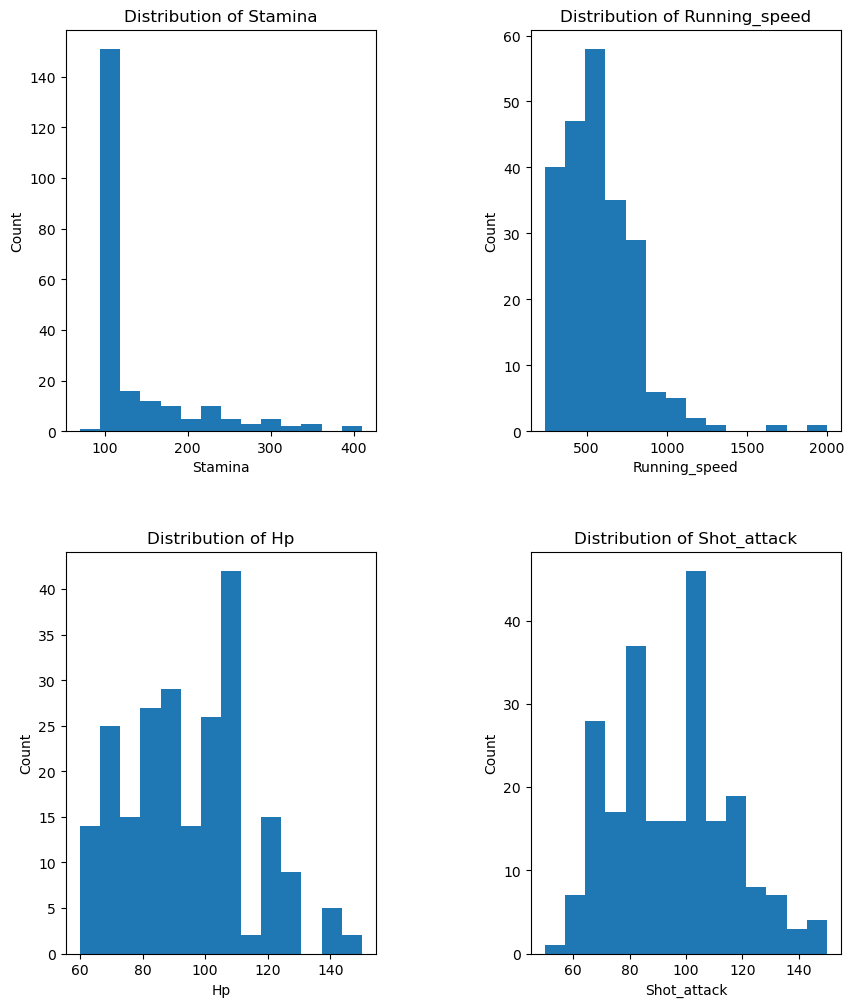

In [128]:
y_feat_list = ['stamina', 'running_speed', 'hp', 'shot_attack']

def hist_subplot(df, y_feat_list):
    for feat in y_feat_list:
        feat_idx = y_feat_list.index(feat)
        plt.subplot(2, 2, feat_idx + 1)

        make_hist(df, feat)

    plt.gcf().set_size_inches(10, 12)
    plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
    plt.show()

hist_subplot(df_pals, y_feat_list)

#### visualization 1

In [5]:
# Write the code to run functions to get each data visualization in separate code chunks. 
# Interpret the figures. 

#### visualization 2

In [6]:
# Write the code to run functions to get each data visualization in separate code chunks. 
# Interpret the figures. 

#### visualization 3

In [7]:
# Write the code to run functions to get each data visualization in separate code chunks. 
# Interpret the figures. 

## Models

### Modeling functions overview
List all the functions you have written for modeling. For each one, write one sentence to describe it. 
- `fit_linear()`
    - fit a linear model to the data and output the r2, slope and intercept

### Model results

- Present 2-3 models for the analysis.
- Explain any pre-processing steps you have done (eg: scaling, polynomial, dummy features)
- For each model, explain why you think this model is suitable and what metrics you want to use to evaluate the model
    - If it is a classification model, you need to present the confusion matrix, calculate the accuracy, sensitivity and specificity with cross-validation
    - If it is a regression model, you need to present the r2 and MSE with cross-validation
    - If it is a linear regression model/multiple linear regression model, you need to interpret the meaning of the coefficient with the full data
    - If it is a decision tree model, you need to plot the tree with the full data
    - If it is a random forest model, you need to present the feature importance plot with the full data
    - If it is a PCA, you need to explain how to select the number of components and interpret the key features in the first two components
    - If it is a clustering, you need explain how to select the number of clustering and summarize the clustering. 

In [8]:
# list all the functions you have for modeling. Make sure write full 
# docstrings for each function
def fit_linear(df, y_feat, x_feat):

    pass

#### Model 1

In [9]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

#### Model 2

In [10]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

#### Model 3

In [11]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

## Discussion

- One or two paragraphs to summarize your findings in the modeling sections and do the models answer your research question?- Any other potential thing you can do with the analysis (eg: include more features, get more data, try some other models etc.)
- List the contribution for each group member.